#**Trabajo Integrador**

Entrega Final - Leandro Blanco.
##Transmisor
Utiliza la placa Easy dsPIC v7 con un dsPIC30F4013.

Los datos digitalizados se envían por UART hacia una PC transmisora.
Un programa en Python toma los símbolos, realiza la modulación PAM4 y transmite por WiFi (TCP) hacia:

El ESP32 canal, que simula el medio de transmisión.
Una laptop de monitoreo, encargada de visualizar las señales.

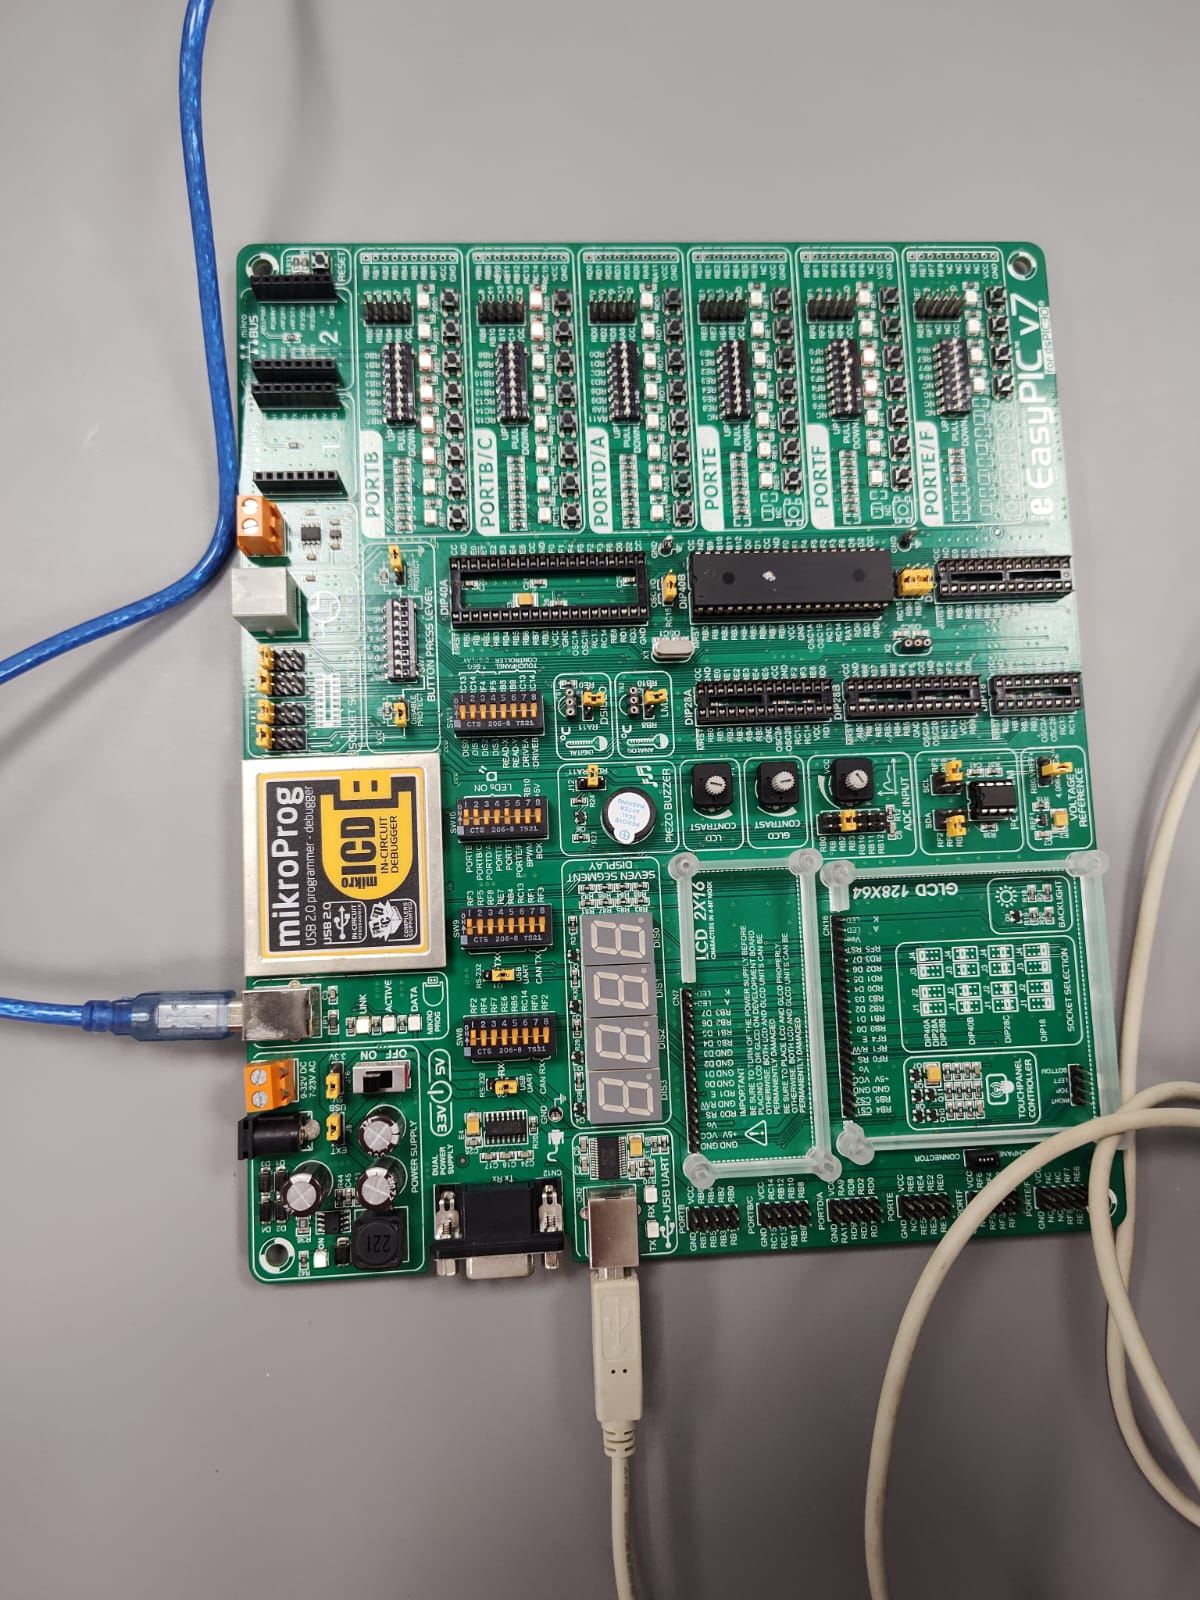

#Codigo del DSPIC


In [ ]:
// dsPIC30F4013
// Placa Easy dsPIC
// Entrada analogica AN8 - VRef es AVdd y AVss -
// Detecta las frecuencias 100 Hz, 200 Hz, 300 Hz, ..., 6300 Hz
// Publica el resultado en binario en los puertos RB0-RB5 (valores desde 1 al 63)

const unsigned long CANT_MUESTRAS = 128;  // 128 pares de valores [Re, Im]
const unsigned long FREC_MUESTREO  = 12800;  // Frecuencia de muestreo.

unsigned Samples[ CANT_MUESTRAS * 2 ];  // Capacidad para 256. Porque son 128 pares

// La funcion FFT requiere que las muestras se almacenen en el bloque de datos Y.
// Este bloque de memoria es una caracteristica de los dsPIC que permite realizar
// operaciones en una sola instruccion, lo que aumenta la velocidad de calculo.
ydata unsigned InputSamples[ CANT_MUESTRAS * 2 ];

// Almacena la frecuencia con mayor potencia en la senal de entrada
unsigned freq = 0;
unsigned freq_old = 0;  // Para almacenar la frecuencia detectada anteriormente. Para ver si se detecto una nueva o no.

// Es un indice para llevar la cuenta de cuantas muestras vamos guardando en Samples.
unsigned globali = 0;

// Bandera para saber si ya se encuentra listo el procesamiento FFT para mostrar el resultado.
char listo = 0;

// Para almacenar lo que se lee por el UART
char uart_rd;
// Para almacenar lo que se escribe a la UART
char uart_wr[ 7 ];


// Para almacenar los valores de cada una de las frecuencias
char magnitudFrecuencias[ CANT_MUESTRAS / 2 ];


void configuracionADC()  {
    ADPCFG = 0b01111111;  // elegimos AN7 como entrada para muestras
    ADCHS = 0b0111; // usamos AN7 para recibir las muestras en el ADC
    ADCON1bits.SSRC = 0b111; //  Internal counter ends sampling and starts conversion (auto convert)
    ADCON1bits.FORM = 0b11;  // Signed Fractional (DOUT = sddd dddd dd00 0000)
    ADCON2bits.VCFG = 0b000;  // tension de referencia Avdd y Avss
}

// Auxiliary function for converting 1.15 radix point to IEEE floating point variable (needed for sqrt).
float Fract2Float( int input )  {
    if ( input < 0 )
        input = - input;
    return ( input / 32768. );
}

// Analiza los componentes de la FFT para luego publicar el resultado en los puertos RB0-RB5
// Las muestras "Samples" contiene la secuencia Re, Im, Re, Im...
void obtenerResultado() {
    unsigned Re, Im, k, max;
    unsigned i = 0;  // Solo como indice para ir avanzando sobre InputSamples
    float    ReFloat, ImFloat, amplitud;

    // La k corresponde al componente, k=0 para la continua, k=1 para 100 Hz,
    // k=2 para 200 Hz, etc. hasta k=63 para 6300 Hz
    k = 0;
    max = 0;  // Almacena el valor maximo de la amplitud de la muestra DFT
    freq = 0;  // Reset current max. frequency for new reading

    // 63 ciclos porque no podria muestrear mas de 63 * 100 Hz = 6300 Hz
    // (que es la mitad de la frecuencia de muestreo)
    while ( k < ( CANT_MUESTRAS / 2 ) )  {
        Re = InputSamples[ i++ ];  // Parte Real de la muestra DFT
        Im = InputSamples[ i++ ];  // Parte Imaginaria de la muestra DFT

        ReFloat = Fract2Float( Re );  // Conversion a float
        ImFloat = Fract2Float( Im );  // Conversion a float

        // Amplitud de la actual muestra DFT
        amplitud = sqrt( ReFloat * ReFloat + ImFloat * ImFloat );

        // DFT esta en escala 1/amplitud, por eso lo volvemos a escala
        amplitud  = amplitud * CANT_MUESTRAS;

        magnitudFrecuencias[ k ] = amplitud;

        if ( k == 0 )
            amplitud = 0;  // Elimina la continua

        if ( amplitud > max ) {
            max = amplitud;  // Almacenamos el valor maximo hasta ahora
            freq = k;  // Almacenamos el componente con mayor potencia
        }

        // Avanzamos de a un componente.
        // En este caso, nos desplzamos 100 Hz cada vez que incrementamos k
        k++;
    }

    // Con esta linea freq tomaria los valores en Hz de la frecuencia con mas potencia.
//    freq *= (FREC_MUESTREO / CANT_MUESTRAS);

    // Desplegamos el valor en los puertos RB0-RB5
    LATBbits.LATB5 = ( freq & 0b0000000000100000 ) >> 5;
    LATBbits.LATB4 = ( freq & 0b0000000000010000 ) >> 4;
    LATBbits.LATB3 = ( freq & 0b0000000000001000 ) >> 3;
    LATBbits.LATB2 = ( freq & 0b0000000000000100 ) >> 2;
    LATBbits.LATB1 = ( freq & 0b0000000000000010 ) >> 1;
    LATBbits.LATB0 = ( freq & 0b0000000000000001 ) >> 0;

//    if ( freq != freq_old )  {
//        UART1_Write_Text( "Frecuencia = " );
//        IntToStr( freq, uart_wr );  // Tener en cuenta que rellane con espacios hasta llegar a 7 chars
//        UART1_Write_Text( uart_wr );
//        UART1_Write( 10 );
//        UART1_Write( 13 );
//    }

    // A continuacion para el envio de los valores de todas las frecuencias
    // Para comenzar se envia || y para terminar tambien ||
    k = 0;

    UART1_Write_Text( "Inicio" );

    while ( k < ( CANT_MUESTRAS / 2 ) )  {
        UART1_Write( magnitudFrecuencias[ k ] );
        k++;
    }

    UART1_Write_Text( "Fin" );

    LATBbits.LATB11 = !LATBbits.LATB11;  // Cada vez que se publica el resultado

//    freq_old = freq;  // freq_old la usamos para actualizar o no lo que se envia al UART, para no repetir los mensajes enviados.
}

unsigned leerAdc()  {
    ADCON1bits.SAMP = 1;  // Pedimos una muestra
    asm nop;  // Tiempo que debemos esperar para que tome una muestra
    ADCON1bits.SAMP = 0;  // Pedimos que retenga la muestra

    return ADCBUF0;  // Devolvemos el valor muestreado por el ADC
}

// Llena Samples con las muestras en Re y Im se pone en 0. Luego copia en el bloque de memoria Y
void SampleInput()  {
    Samples[ globali++ ] = leerAdc();   // Re
    Samples[ globali++ ] = 0;           // Im

    LATFbits.LATF1 = !LATFbits.LATF1;  // En este puerto se puede ver la frecuencia de muestreo

    // Entra a este if cuando ya tiene 128 pares.
    if ( globali >= ( CANT_MUESTRAS * 2 ) )  {
        globali = 0;
        if ( ! listo )  {  // Todavia no tenemos suficientes muestras

            // Copiamos las muestras del ADC hacia el bloque de memoria Y
            memcpy( InputSamples, Samples, CANT_MUESTRAS * 2 );

            // Ya estamos listos para aplicar FFT.
            // Esto habilita el uso de la funcion FFT en la funcion main()
            listo = 1;
        }
    }
}

void  configuracionPuertos()  {
    TRISFbits.TRISF1 = 0;  // Debug frec de muestreo
    TRISBbits.TRISB11 = 0;  // Debug cada vez que se publica el resultado

    // Lo siguientes puertos para mostrar la frecuencia con mayor potencia
    TRISBbits.TRISB0 = 0;
    TRISBbits.TRISB1 = 0;
    TRISBbits.TRISB2 = 0;
    TRISBbits.TRISB3 = 0;
    TRISBbits.TRISB4 = 0;
    TRISBbits.TRISB5 = 0;

    TRISBbits.TRISB7 = 1;  // AN7 para entrada analogica

}

void detectarT2() org 0x0020  {
    SampleInput();  // Se encarga de tomar las muestras
    IFS0bits.T2IF = 0;  // Bandera Timer 2
}

void configuracionT2()  {
    PR2 = ( unsigned long )( Get_Fosc_kHz() ) * 1000 / ( 4 * FREC_MUESTREO );
    IEC0bits.T2IE = 1;  // Habilitamos interrucion del Timer 2
}

void main()  {

    UART1_Init(9600);              // Initialize UART module at 9600 bps
    Delay_ms(100);                 // Wait for UART module to stabilize

//    UART1_Write_Text("Programa iniciado!!!");
//    UART1_Write(10);
//    UART1_Write(13);


    // Ponemos en cero el buffer para las muestras
    memset( InputSamples, 0, CANT_MUESTRAS * 2 );

    // Ponemos en cero el array que contendra las magnitudesd e todas las frecuencias
    memset( magnitudFrecuencias, 0, CANT_MUESTRAS / 2 );

    configuracionPuertos();

    configuracionT2();
    T2CONbits.TON = 1;  // Encendemos Timer 2

    configuracionADC();
    ADCON1bits.ADON = 1;  // Encendemos el ADC

    while ( 1 )  {
        if ( listo ) {
            // Calcula FFT en 7 etapas, 128 pares de muestras almacenados en InputSamples.
            FFT( 7, TwiddleCoeff_128, InputSamples );

            // Necesario para acomodar en orden natural los bits.
            BitReverseComplex( 7, InputSamples );

            obtenerResultado();  // Analiza la amplitud de las muestras DFT y publica resultados en RB0-RB5

            listo = 0;  // Indicamos que publicamos un resultado y ahora esperamos el proximo analisis
        }

//        if (UART1_Data_Ready()) {     // If data is received,
//            uart_rd = UART1_Read();     // read the received data,
//            UART1_Write(uart_rd);       // and send data via UART
//        }

    }
}

**Explicación del código:**

Este código C está diseñado para un microcontrolador dsPIC30F4013. Su propósito principal es detectar frecuencias dominantes en una señal analógica de entrada utilizando el algoritmo de la Transformada Rápida de Fourier (FFT). Esto es lo que hace:

- Entrada Analógica y Muestreo:
 Muestrea continuamente una señal analógica del pin AN7 a una frecuencia de 12.8 kHz (FREC_MUESTREO). Estas muestras se almacenan en el array Samples.

- Procesamiento FFT:
Una vez que se recolectan 128 muestras, se copian a un bloque de memoria especializado (InputSamples) y se aplica el algoritmo FFT. Esto convierte la señal del dominio del tiempo en sus componentes de frecuencia.

- Detección de Frecuencia:
Después de la FFT, el código itera a través de los componentes de frecuencia para calcular la magnitud (amplitud) de cada uno. Luego identifica el componente de frecuencia con la mayor magnitud, que representa la frecuencia dominante en la señal de entrada (que va desde 100 Hz hasta 6300 Hz).

- Salida:
La frecuencia dominante detectada se envía en formato binario a los pines RB0-RB5.
Además, las magnitudes de todos los componentes de frecuencia detectados se envían a través de UART (Transmisor-Receptor Asíncrono Universal) a otro dispositivo, delimitadas por los mensajes "Inicio" y "Fin".
En esencia, funciona como un analizador de espectro en tiempo real para un sistema embebido.

#**Código de la PC:**

In [ ]:
import serial
import matplotlib.pyplot as plt
import time
import socket
import numpy as np

# Configuración del puerto serie
PORT = 'COM3'
BAUDRATE = 9600

# Frecuencias esperadas (100 Hz a 6300 Hz en pasos de 100 Hz)
freqs = [i * 100 for i in range(1, 65)]

# Destinos TCP (IP, puerto)
destinos = [
    ("10.0.0.83", 5051),
    ("10.0.1.173", 8100)
]

# Modulación PAM4 directa desde bytes
def mod_pam4_desde_bytes(byte_list):
    bits = ''.join(f'{b:08b}' for b in byte_list)  # 8 bits por byte
    symbols = [int(bits[i:i+2], 2) for i in range(0, len(bits), 2)]  # 2 bits por símbolo
    packed = []
    print("\nEmpaquetado de símbolos PAM4 en bytes:")
    for i in range(0, len(symbols), 4):
        grupo = symbols[i:i+4]
        byte = (grupo[0] << 6) | (grupo[1] << 4) | (grupo[2] << 2) | grupo[3]
        packed.append(byte)
        print(f"Símbolos: {grupo} → Byte: {byte} (bin: {byte:08b})")
    return packed, symbols

# Envío TCP
def enviar(ip, port, datos):
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect((ip, port))
            s.sendall(bytes(datos))
            print(f"Enviado {len(datos)} bytes a {ip}:{port}")
    except Exception as e:
        print(f"Error al enviar a {ip}:{port} → {e}")

# Reconstrucción de señal compuesta usando IFFT
def reconstruir_senal(amplitudes, freqs, fs=44100, duracion=0.1):
    N = int(fs * duracion)
    espectro = np.zeros(N, dtype=complex)
    for f, A in zip(freqs, amplitudes):
        idx = int(f * duracion)
        if idx < N:
            espectro[idx] = A + 0j
    senal = np.fft.ifft(espectro).real
    t = np.linspace(0, duracion, N, endpoint=False)
    return t, senal

# Inicializar gráfico
plt.ion()

# Abrir puerto serie
with serial.Serial(PORT, BAUDRATE, timeout=1) as ser:
    try:
        while True:
            # Esperar "Inicio"
            buffer = b""
            while b"Inicio" not in buffer:
                buffer += ser.read(1)

            # Leer 64 bytes de datos
            amplitudes = []
            while len(amplitudes) < 64:
                byte = ser.read(1)
                if byte:
                    amplitudes.append(ord(byte))

            # Esperar "Fin"
            buffer = b""
            while b"Fin" not in buffer:
                buffer += ser.read(1)

            # Agregar la palabra "hola" al inicio del vector
            palabra = [ord(c) for c in "hola"]  # [104,111,108,97]
            amplitudes = palabra + amplitudes  # Ahora son 68 bytes

            # Imprimir vector recibido
            print("\nVector enviado (68 valores decimales):")
            print(amplitudes)

            # Modulación PAM4 directa
            datos, symbols = mod_pam4_desde_bytes(amplitudes)

            # Imprimir cantidad y lista de símbolos PAM4
            print(f"\nCantidad de símbolos PAM4: {len(symbols)}")
            #print("Símbolos PAM4:")
            #print(symbols)

            # Enviar a cada destino
            for ip, port in destinos:
                enviar(ip, port, datos)

            # Reconstruir señal compuesta (solo con las 64 amplitudes originales)
            t, senal = reconstruir_senal(amplitudes[4:], freqs)

            # Zoom de 20 ms
            zoom_duracion = 0.010
            N_zoom = int(44100 * zoom_duracion)
            t_zoom = t[:N_zoom]
            s_zoom = senal[:N_zoom]

            # Graficar
            plt.clf()

            # 1. Frecuencias y amplitudes
            plt.subplot(3, 1, 1)
            plt.bar(freqs, amplitudes[4:], width=80)
            plt.title("Magnitudes de Frecuencia recibidas (8 bits)")
            plt.xlabel("Frecuencia [Hz]")
            plt.ylabel("Valor (0–255)")

            # 2. Histograma de símbolos PAM4
            plt.subplot(3, 1, 2)
            counts = [symbols.count(i) for i in range(4)]
            plt.bar(range(4), counts, tick_label=["0", "1", "2", "3"])
            plt.title("Histograma de símbolos PAM4")
            plt.xlabel("Símbolo")
            plt.ylabel("Cantidad")

            # 3. Señal reconstruida (Zoom 10 ms)
            # Es una señal simulada ya que para reconstruir la señal necesitariamos las fases del Ak aparte de sus módulos.
            plt.subplot(3, 1, 3)
            plt.plot(t_zoom, s_zoom)
            plt.title("Señal reconstruida Simulada con fase 0 (Zoom 10 ms)")
            plt.xlabel("Tiempo [s]")
            plt.ylabel("Amplitud")

            plt.tight_layout()
            plt.pause(0.01)
            time.sleep(1)

    except KeyboardInterrupt:
        print("Programa finalizado por el usuario.")

##Explicacion del Código:

Este código Python está diseñado para funcionar en una PC, interactuando con el microcontrolador dsPIC y otros dispositivos a través de TCP. A continuación, el detallo de sus funcionalidades:

**- Configuración inicial:**

Define el puerto serie (COM3) y la velocidad de comunicación (9600 baudios) para conectarse con el dsPIC.
Establece las frecuencias esperadas (de 100 Hz a 6300 Hz en pasos de 100 Hz, un total de 64 frecuencias).
Configura las direcciones IP y puertos de destino para la comunicación TCP.

**- Modulación PAM4** (Pulse Amplitude Modulation 4-level):

La función mod_pam4_desde_bytes toma una lista de bytes, los convierte en una secuencia de bits.
Luego, agrupa estos bits en pares de 2 (símbolos PAM4, que pueden ser 0, 1, 2 o 3).
Finalmente, empaqueta cuatro símbolos PAM4 en un solo byte para una transmisión más eficiente.

**- Envío de datos TCP:**

La función enviar establece una conexión TCP con un destino especificado (IP y puerto).
Envía los datos empaquetados en formato de bytes a ese destino.

**- Reconstrucción y visualización de la señal:**

La función reconstruir_senal utiliza las amplitudes de frecuencia recibidas para crear un espectro.
Aplica una Transformada Inversa de Fourier (IFFT) para reconstruir una señal de tiempo simulada a partir de esas amplitudes.

**- Ciclo principal de operación (bucle while True):**

- **Lectura del puerto serie:**
Se conecta al puerto serie y espera los marcadores "Inicio" y "Fin" para recibir 64 bytes de datos de amplitud de frecuencia desde el dsPIC. Estos 64 bytes corresponden a las magnitudes de las frecuencias detectadas.

- **Pre-procesamiento:** Añade la palabra "hola" (como una lista de 4 bytes) al principio del vector de amplitudes recibido, resultando en un total de 68 bytes.
Modulación y envío: Modula estos 68 bytes utilizando la técnica PAM4 y los envía a todos los destinos TCP configurados.

**- Gráficos en tiempo real:**
Muestra un gráfico de barras con las magnitudes de frecuencia recibidas.
Genera un histograma de los símbolos PAM4 modulados.
Reconstruye una señal de tiempo simulada (usando las 64 amplitudes originales) y muestra un zoom de 10 ms de esta señal.
En resumen, este script actúa como un puente entre el dsPIC (que detecta frecuencias y las envía por serie) y otros dispositivos (que reciben los datos modulados por TCP), además de proporcionar una visualización en tiempo real del proceso.


##Visualizaciones:

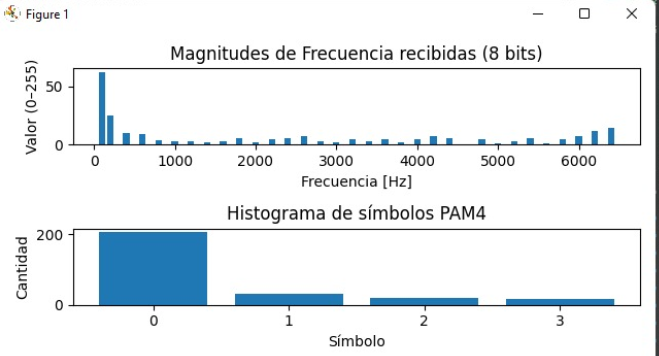

In [ ]:
Vector enviado (68 valores decimales):
[104, 111, 108, 97, 63, 18, 0, 11, 0, 5, 0, 8, 0, 9, 0, 2, 0, 3, 0, 8, 0, 4, 0, 1, 0, 2, 0, 6, 0, 5, 0, 2, 0, 0, 0, 4, 0, 3, 0, 4, 0, 2, 0, 11, 0, 5, 0, 3, 0, 1, 0, 2, 0, 10, 0, 7, 0, 5, 0, 13, 0, 5, 0, 3, 0, 5, 0, 18]


Empaquetado de símbolos PAM4 en bytes:
Símbolos: [1, 2, 2, 0] → Byte: 104 (bin: 01101000)
Símbolos: [1, 2, 3, 3] → Byte: 111 (bin: 01101111)
Símbolos: [1, 2, 3, 0] → Byte: 108 (bin: 01101100)
Símbolos: [1, 2, 0, 1] → Byte: 97 (bin: 01100001)
Símbolos: [0, 3, 3, 3] → Byte: 63 (bin: 00111111)
Símbolos: [0, 1, 0, 2] → Byte: 18 (bin: 00010010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 3] → Byte: 11 (bin: 00001011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 0] → Byte: 8 (bin: 00001000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 1] → Byte: 9 (bin: 00001001)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 0] → Byte: 8 (bin: 00001000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 0] → Byte: 4 (bin: 00000100)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 1] → Byte: 1 (bin: 00000001)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 2] → Byte: 6 (bin: 00000110)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 0] → Byte: 4 (bin: 00000100)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 0] → Byte: 4 (bin: 00000100)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 3] → Byte: 11 (bin: 00001011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 1] → Byte: 1 (bin: 00000001)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 2] → Byte: 10 (bin: 00001010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 3] → Byte: 7 (bin: 00000111)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 3, 1] → Byte: 13 (bin: 00001101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 1, 0, 2] → Byte: 18 (bin: 00010010)

Cantidad de símbolos PAM4: 272
Enviado 68 bytes a 10.0.0.83:5051
Enviado 68 bytes a 10.0.1.173:8100